In [1]:
using Symbolics
using Latexify
using BenchmarkTools
include("RBFunctions.jl")
using Plots
using LinearAlgebra
using IterativeSolvers

In [2]:
@variables ϵ r x₁ x₂ ;
#r = sqrt(x₁^2 + x₂^2)
#ϕ = exp(-r^2*ϵ^2)
ϕ = (1-r*ϵ)^8 * (32*(r*ϵ)^3 + 25* (r*ϵ)^2 + 8*r*ϵ + 1)
#ϕ = (1-r*ϵ)^4 * (4r*ϵ+1)
#ϕ = substitute(ϕ, r=>sqrt(x₁^2 + x₂^2)) 
#ϕ = substitute(ϕ, r=>sqrt(x₁^2 + x₂^2))
ϕ = simplify(ϕ,expand = true)
display(ϕ)  
#Δ(exprs) = expand_derivatives((Differential(x₁)^2)(exprs) + (Differential(x₂)^2)(exprs))
∂₁(exprs) = simplify(expand_derivatives(Differential(x₁)(exprs)) + expand_derivatives(Differential(r)(exprs)) * (x₁/r),expand = true)
∂₂(exprs) = simplify(expand_derivatives(Differential(x₂)(exprs)) + expand_derivatives(Differential(r)(exprs)) * (x₂/r),expand = true)
Δ(exprs) = ∂₁(∂₁(exprs)) + ∂₂(∂₂(exprs))
∂ₜ(exprs) = expand_derivatives(Differential(t)(exprs))

Φ_div = ([-∂₂(∂₂(ϕ)) ∂₁(∂₂(ϕ)) ; ∂₁(∂₂(ϕ)) -∂₁(∂₁(ϕ))])
Φ_div = substitute.(Φ_div,r=>sqrt(x₁^2 + x₂^2))

Φ_div = substitute.([ϕ 0.0 ; 0.0 ϕ],r=>sqrt(x₁^2 + x₂^2))
λ1(x) = x[1]
λ2(x) = x[2]
phi = eval(build_function(substitute(ϕ, r=>sqrt(x₁^2 + x₂^2)), [x₁, x₂], ϵ))
#simplified = substitute(simplify(∂₁(∂₁(ϕ))), r=>sqrt(x₁^2 + x₂^2)) 
#simplified = eval(build_function(simplified, [x₁, x₂], ϵ))

#singular = substitute(∂₁(∂₁(ϕ)), r=>sqrt(x₁^2 + x₂^2)) 
#singular = eval(build_function(singular, [x₁, x₂], ϵ))
display(Φ_div)
#phi([0,0],10)

(1//1) + (66//1)*(r^4)*(ϵ^4) + (1056//1)*(r^7)*(ϵ^7) + (704//1)*(r^9)*(ϵ^9) + (32//1)*(r^11)*(ϵ^11) - (11//1)*(r^2)*(ϵ^2) - (462//1)*(r^6)*(ϵ^6) - (231//1)*(r^10)*(ϵ^10) - (1155//1)*(r^8)*(ϵ^8)

2×2 Matrix{Num}:
 (1//1) + (32//1)*(ϵ^11)*(sqrt(x₁^2 + x₂^2)^11) + (66//1)*(ϵ^4)*(sqrt(x₁^2 + x₂^2)^4) + (1056//1)*(ϵ^7)*(sqrt(x₁^2 + x₂^2)^7) + (704//1)*(ϵ^9)*(sqrt(x₁^2 + x₂^2)^9) - (11//1)*(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2) - (462//1)*(ϵ^6)*(sqrt(x₁^2 + x₂^2)^6) - (231//1)*(ϵ^10)*(sqrt(x₁^2 + x₂^2)^10) - (1155//1)*(ϵ^8)*(sqrt(x₁^2 + x₂^2)^8)    …                                                                                                                                                                                                                                                                                                                                  0.0
                                                                                                                                                                                                                                                                                                                                 0.0     (

In [3]:
K = construct_kernel_array(Φ_div,[λ1,λ2],[λ1,λ2])
display(K)
K = compile_kernel_array(K)
K[1,1]([0.0,0.0],1)

2×2 Matrix{Num}:
 (1//1) + (32//1)*(ϵ^11)*(sqrt(x₁^2 + x₂^2)^11) + (66//1)*(ϵ^4)*(sqrt(x₁^2 + x₂^2)^4) + (1056//1)*(ϵ^7)*(sqrt(x₁^2 + x₂^2)^7) + (704//1)*(ϵ^9)*(sqrt(x₁^2 + x₂^2)^9) - (11//1)*(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2) - (462//1)*(ϵ^6)*(sqrt(x₁^2 + x₂^2)^6) - (231//1)*(ϵ^10)*(sqrt(x₁^2 + x₂^2)^10) - (1155//1)*(ϵ^8)*(sqrt(x₁^2 + x₂^2)^8)    …                                                                                                                                                                                                                                                                                                                                  0.0
                                                                                                                                                                                                                                                                                                                                 0.0     (

1.0

In [4]:
N_coll = 99
I_points,B_points = generate_2D_equally_spaced_points(N_coll)
All_points = hcat(I_points,B_points)
All_points = All_points
Test_points = hcat(generate_2D_equally_spaced_points(117)...)
N_tot = size(All_points)[2]
#scatter(All_points[1,:],All_points[2,:])

9801

In [5]:
r = 10/(N_coll-1)
#A = sparse_point_difference_tensor(I_points,I_points,0.03)
#A = sparse_point_difference_tensor(All_points,All_points,0.017)
#A = apply(phi, A,1)
A = sparse_block_point_tensors([All_points,All_points],[All_points,All_points],r)
A = generate_block_matrices(K,A,1/r)
A = flatten(A)
A = sparse(A)


B = sparse_block_point_tensors([Test_points,Test_points],[All_points,All_points],r)
B = generate_block_matrices(K,B,1/r)
B = flatten(B)
B = sparse(B)

#display(DD)
println(nnz(A)/(A.m*A.n))
#heatmap(Matrix(A))

0.029336422082369466


In [11]:

e = 0.7*16
r = 1/e
S = sparse_point_difference_tensor(All_points,All_points,r)
E = sparse_point_difference_tensor(Test_points,All_points,r)
S = sparse(apply(phi,S,e))
#display(S)
E = sparse(apply(phi,E,e))
b = frankes_func.(All_points[1,:],All_points[2,:])
ref_sol = frankes_func.(Test_points[1,:],Test_points[2,:])
#println(maximum(ref_sol))
c = cg(S,b)
error = E*c - ref_sol
#surface(Test_points[1,:],Test_points[2,:],abs.(error))
RMS = sqrt(sum(error .^2/length(error)))
#maximum(error)

#show that there is no convergence
N = append!(collect(5:5:80),[100,150,200,250,500])
RMS_array = []

for n in N
    #generate collocation points 
    r = 5/(n-1)
    coll_points = hcat(generate_2D_equally_spaced_points(n)...)
    S = sparse_point_difference_tensor(coll_points,coll_points,r)
    E = sparse_point_difference_tensor(Test_points,coll_points,r)
    S = sparse(apply(phi,S,1/r))
    E = sparse(apply(phi,E,1/r))
    b = frankes_func.(coll_points[1,:],coll_points[2,:])
    ref_sol = frankes_func.(Test_points[1,:],Test_points[2,:])
    c = cg(S,b)
    error = E*c - ref_sol
    RMS = sqrt(sum(error .^2/length(error)))
    append!(RMS_array,[RMS])
end

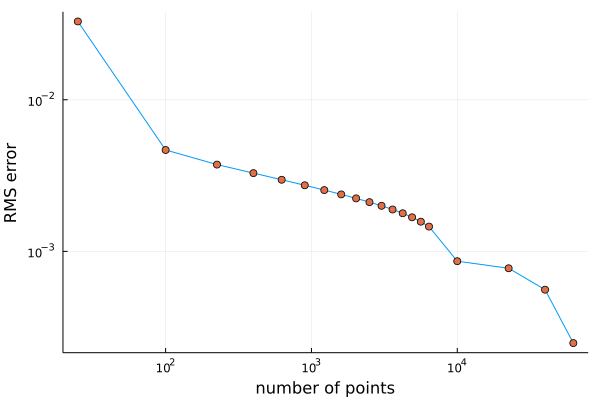

In [10]:
plot(N .^2,RMS_array,yscale = :log10,label=false,xscale = :log10)
scatter!(N .^2,RMS_array,yscale = :log10,xlabel="number of points",ylabel="RMS error",label=false)


In [8]:
#test problem 
function true_v1(x,y)
    return 20*x*y^3
end
function true_v2(x,y)
    return 5*x^4 - 5*y^4
end
b = vcat(true_v1.(All_points[1,:],All_points[2,:]),true_v2.(All_points[1,:],All_points[2,:]))
reference_v = vcat(true_v1.(Test_points[1,:],Test_points[2,:]),true_v2.(Test_points[1,:],Test_points[2,:]))

27378-element Vector{Float64}:
 1.1045821957609494e-7
 8.836657566087595e-7
 2.9823719285545633e-6
 7.069326052870076e-6
 1.380727744701187e-5
 2.3858975428436507e-5
 3.788716931460057e-5
 5.655460842296061e-5
 8.052404207097323e-5
 0.00011045821957609496
 0.00014701989025578234
 0.00019087180342749205
 0.0002426767084086806
 ⋮
 1.6434335935346067
 1.5137260685639786
 1.3802951626987712
 1.2430702931366744
 1.1019802143260593
 0.9569530179659855
 0.8079161330061888
 0.6547963256470899
 0.49751969933979545
 0.33601169478609005
 0.17019708993843974
 0.0

In [9]:
sol = cg(A,b)
error = B*sol-reference_v
println(sqrt(sum(error .^2)/length(error)))

0.0013462482196075736
